## Convolutional Neural Network (CNN) Model implementation for Music Genre Classification

### Data Preparation

We use GTZAN audio files in .wav format as data for training CNN model to predict different music genres. We have extracted mel spectrogram features, which are 2d visualizal representations of the audio files. 

Some points we need to take care before modelling:

1. Values of the mel spectrograms should be scaled so that they are between 0 and 1 for computational efficiency.
2. The data is currently 1000 rows of mel spectrograms that are 128 x 660. We need to reshape this to be 1000 rows of 128 x 660 x 1 to represent that there is a single color channel. If our image had three color channels, RGB, we would need this additional dimension to be 3. 
3. Target values have to be one-hot-encoded in order to be fed into a neural network.



In [4]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical

In [5]:
labels = []
mel_specs = []

for dirname, _, filenames in os.walk('../input/gtzan-dataset-music-genre-classification/Data/genres_original'):
    
    for filename in filenames: 
        
        file=os.path.join(dirname, filename)
        if(file!='../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav'):
            
            # Loading in the audio file
            y, sr = librosa.load(file)            
            # Extracting the label and adding it to the list
            label = str(file).split('.')[0].split('/')[-1]
            labels.append(label)
            
            

            # Computing the mel spectrograms
            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
            spect = librosa.power_to_db(spect, ref=np.max)

            # Adjusting the size to be 128 x 660
            if spect.shape[1] != 660:
                spect.resize(128,660, refcheck=False)

            mel_specs.append(spect)
        

In [6]:
# Converting the list or arrays to an array
X = np.array(mel_specs)
    
# Converting labels to numeric values
labels = pd.Series(labels)
label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
}

y = labels.map(label_dict).values

In [7]:
print(X.shape,y.shape)

(999, 128, 660) (999,)


In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

In [9]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(799, 128, 660) (200, 128, 660) (799,) (200,)


In [10]:
# Checking the minimum value (the scale ranges from zero to some negative value) to see how we should scale the data
X_train.min()

-80.0

In [11]:
X_train /= -80
X_test /= -80

In [12]:
X_train.min(), X_train.max()

(-4.7683717e-08, 1.0)

In [13]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

In [14]:
# One hot encoding our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [15]:
print(y_train.shape,y_test.shape)

(799, 10) (200, 10)


In [16]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## CNN model implementation and fitting on the train dataset. 

Here, CNN model is defined with stack of layers: Convolution2D layer, followed by MaxPooling layer, again Convolution2D layer, followed by MaxPooling layer, then Flatten layer which creates single dimensional array of outputs. These outputs are the passed to Dense (Fully Connected) layer with 'relu' as activation function.DropOut of 0.25 portion is used to control model from overfitting. The final layer is again defined a Dense layer with 10 outputs. We use softmax activation function in the final layer in order to predict probabilities for 10 genres.

In [17]:
#Constructing CNN
np.random.seed(23456)
tf.random.set_seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Epoch 1/15
50/50 [==============================] - 18s 369ms/step - loss: 2.3872 - accuracy: 0.0976 - val_loss: 2.2989 - val_accuracy: 0.1250
Epoch 2/15
50/50 [==============================] - 18s 352ms/step - loss: 2.2676 - accuracy: 0.1377 - val_loss: 2.1756 - val_accuracy: 0.2200
Epoch 3/15
50/50 [==============================] - 17s 349ms/step - loss: 2.0428 - accuracy: 0.2240 - val_loss: 1.8958 - val_accuracy: 0.2100
Epoch 4/15
50/50 [==============================] - 18s 368ms/step - loss: 1.8471 - accuracy: 0.2841 - val_loss: 1.6849 - val_accuracy: 0.3900
Epoch 5/15
50/50 [==============================] - 18s 353ms/step - loss: 1.6209 - accuracy: 0.4130 - val_loss: 1.5422 - val_accuracy: 0.5600
Epoch 6/15
50/50 [==============================] - 18s 359ms/step - loss: 1.4670 - accuracy: 0.4531 - val_loss: 1.7108 - val_accuracy: 0.3800
Epoch 7/15
50/50 [==============================] - 18s 363ms/step - loss: 1.3265 - accuracy: 0.5081 - val_loss: 1.4034 - val_accuracy: 0.4850

In [18]:

# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2457664   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

### Visualizing the loss for train dataset against test dataset.

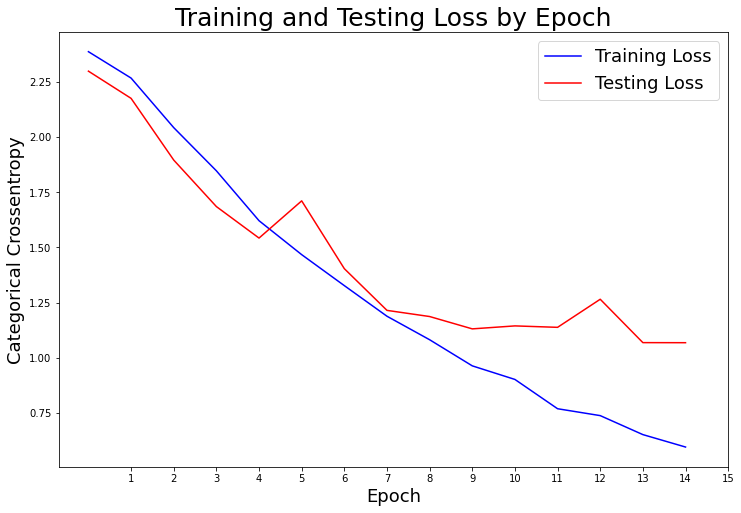

In [19]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18)

### Visualizing the accuracy of train dataset vs test dataset

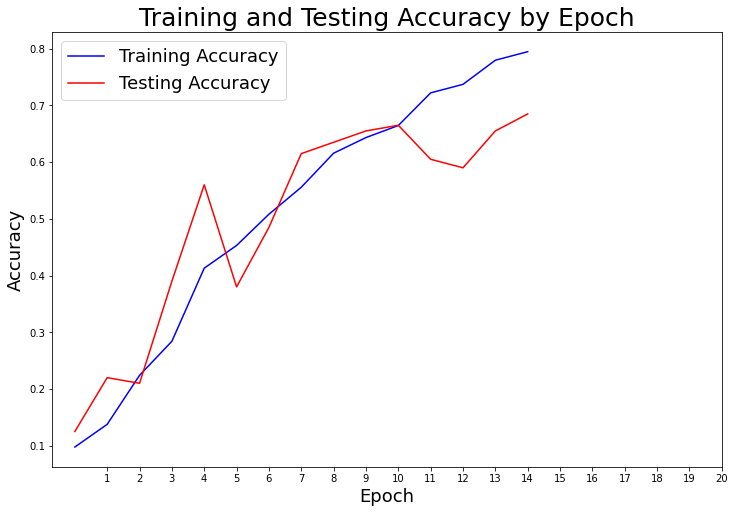

In [20]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18)

We observed that the CNN model became increasingly overfit after about 15-20 epochs, so increasing the number of epochs would likely not improve the model.

In [21]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)

7/7 [==============================] - 1s 182ms/step


Building Confusion Matrix to visualize the model's predictions against the actual values. 
since the confusion matrix function from sklearn does not return the labels for predicted values and actual values, I checked how many predicted and actual values there were for each genre to be able to figure it out


In [22]:
# Checking the number of targets that is genre labels per class
for i in range(10): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 20
1: 20
2: 20
3: 20
4: 20
5: 20
6: 20
7: 20
8: 20
9: 20


In [23]:
# Checking the number of predicted values in each class
for i in range(10): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 25
1: 25
2: 21
3: 36
4: 22
5: 11
6: 17
7: 15
8: 10
9: 18


In [25]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[17,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  3,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  6,  1,  0,  1,  0,  1,  1],
       [ 2,  3,  0, 14,  1,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  1, 16,  0,  0,  0,  0,  0],
       [ 1,  1,  4,  5,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  2,  2,  0,  0, 16,  0,  0,  0],
       [ 4,  0,  0,  1,  0,  0,  0, 15,  0,  0],
       [ 1,  4,  1,  2,  1,  1,  0,  0,  9,  1],
       [ 0,  0,  0,  1,  2,  1,  0,  0,  0, 16]])

In [27]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
# Creating a dictionary of labels
labels_dict = {
    0: 'jazz',
    1: 'reggae',
    2: 'rock',
    3: 'blues',
    4: 'hiphop',
    5: 'country',
    6: 'metal',
    7: 'classical',
    8: 'disco',
    9: 'pop'
}
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,reggae,rock,blues,hiphop,country,metal,classical,disco,pop
jazz,17,0,0,3,0,0,0,0,0,0
reggae,0,15,3,1,1,0,0,0,0,0
rock,0,0,10,6,1,0,1,0,1,1
blues,2,3,0,14,1,0,0,0,0,0
hiphop,0,2,1,1,16,0,0,0,0,0
country,1,1,4,5,0,9,0,0,0,0
metal,0,0,2,2,0,0,16,0,0,0
classical,4,0,0,1,0,0,0,15,0,0
disco,1,4,1,2,1,1,0,0,9,1
pop,0,0,0,1,2,1,0,0,0,16


[Text(74.5, 0.5, 'Actual Values'), Text(0.5, 56.5, 'Predicted Values')]

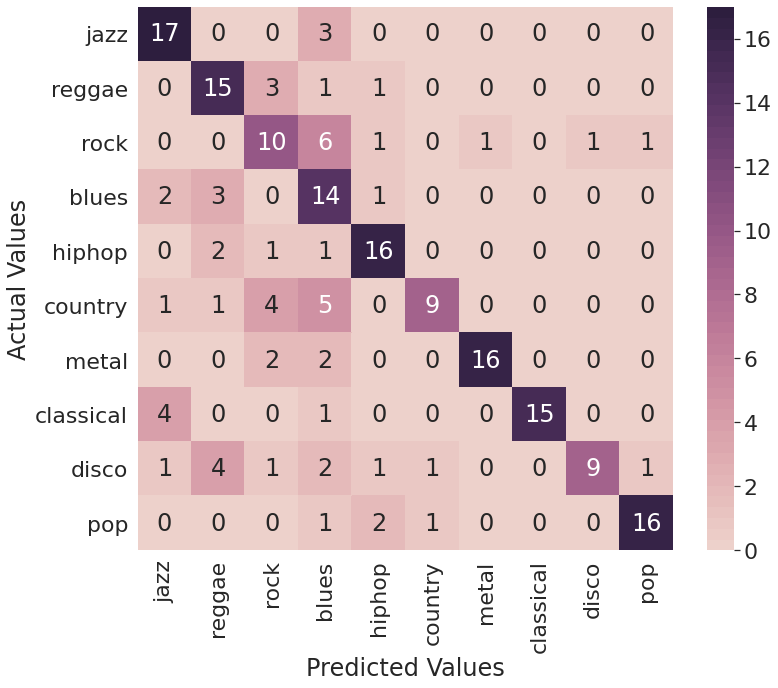

In [29]:
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (12,10))
sns.set(font_scale = 2)
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(50))
ax.set(xlabel='Predicted Values', ylabel='Actual Values')

## Summary :


The best CNN model (based on test score accuracy) achieved a score of 68%. The training score was 84%, so the model was overfit. This means that it was tuning really well to the training data and not generalizing as well to new data.

The model became increasingly overfit after about 15-20 epochs, so increasing the number of epochs likely would not improve the model.
 
Based on the confusion matrix, the computer was confusing some genres for others similarly to how humans would. For example, most of the misclassifications for blues was either jazz or rock. This makes sense because blues heavily influenced rock music, and shares several characteristics with both rock and jazz. Raggea and hiphop were also mixed up, which makes sense because hiphop was influenced by reggae.

Our model is running into the same difficulties that a human would. It's clearly learning some of the distinguishing
factors of the musical genres, but it is having trouble with genres that share characteristics with other genres